# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image
from extractor import FeaturesExtractor

# Sklearn
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (16, 8)

## Formal Statement

На шаг было потрачено не более часа.

Разберемся с формальной постановкой задачи.
1. Нам нужно научиться разделять позитивные и негативные отзывы. Казалось бы подойдет вариант решения задачи бинарной классификации, но интуиция подсказывает, что зачастую отзывы бывают нейтрального характера, поэтому их будет сложно с увереностью отнести к какому-либо классу. Поэтому, мы будем решать задачу классификации с k=5 классами - оценками, поставленными юзером к отзыву.
2. Целевые значения - проставленная юзером оценка (в баллах), которая идет в дополнение к отзыву. Оценка будет краситься красным если она меньше 3, желтым если она равна 3 и зеленым иначе.
3. Оценивать будем с помощью точности предсказаний на классах для тестовой выборки.
4. Демонстрация будет работать на примерах на русском языке (данным собираются на русском сайте). Мы будем оценивать тональность введенного пользователем текста. Размер текста - от пары предложений до пары абзацев (люда, которые пишут о своих деньгах, обычно дотошны и подробны). Ввиду малой обучающей выборки, наврятли получится хорошо учитывать сленговую лексику. Корректора ошибок не будет, а выборка небольшая, так что работать будет лучше на примерах без грамматических ошибок.

## Collecting Data

Будем парсить отзывы о банках вместе с метаинфой с сайта http://www.banki.ru/.  
Реализация на `scrapy` получилась достаточно простой и эффективной. Сдесь, мы просто запускаем кравлер, сохраняя результаты в csv.  
Реализация этого шага заняла пару часов.

Uncomment, чтобы заработал кравлер (~40 минут).

In [2]:
# %%time
# !cd banki && scrapy crawl banki -o ../banki.csv -t csv -s LOG_LEVEL=INFO -s CLOSESPIDER_ITEMCOUNT=5000

Посмторим, что внутри.

In [3]:
!du -sh banki.csv

5.1M	banki.csv


In [4]:
df = pd.read_csv('banki.csv')
df.head()

,url,time,bank,title,text,comments,views,score
0,http://www.banki.ru/services/responses/bank/re...,2017-12-17 23:06:41,Совкомбанк,Мой печальный опыт автокредитования,Добрый день!9 декабря 2017 года мною был оформ...,0,7,3
1,http://www.banki.ru/services/responses/bank/re...,2017-12-17 22:12:36,Русфинанс Банк,13-й платеж НЕ в подарок,"Взяла товар в кредит, по акции ""13 платеж в по...",0,29,3
2,http://www.banki.ru/services/responses/bank/re...,2017-12-17 14:57:10,Тинькофф Банк,Приятно удивлен,"Даже не смотря на то,что банк по неивестным мн...",0,267,5
3,http://www.banki.ru/services/responses/bank/re...,2017-12-17 15:07:53,Бинбанк Диджитал,Неоднозначные впечатления от пользования карто...,"Добрый день, уважаемые сотрудники Бинбанка и п...",0,233,3
4,http://www.banki.ru/services/responses/bank/re...,2017-12-17 15:10:27,Тинькофф Банк,Отзыв о Тинькофф банке,ИНН 682805481033,0,271,5


In [5]:
df = df.fillna('')

In [6]:
len(np.unique(df.bank))

139

Посмотрим на метки классов - видно смещение, слишком много классов с 1 (видимо, разгневанных пользователей).

In [7]:
np.unique(df.score)

array([1, 2, 3, 4, 5])

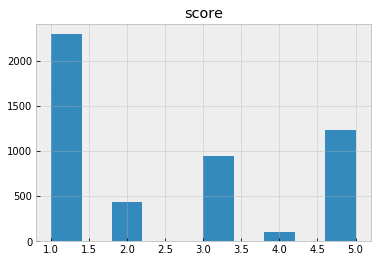

In [8]:
df.hist('score');

Немного обработаем данные - сократим количество записей до круглого и распарсим время.

In [9]:
before_len = len(df)
df = df.iloc[:5000]
after_len = len(df)
f'Trim df from {before_len} rows to {after_len} rows.'

'Trim df from 5016 rows to 5000 rows.'

In [10]:
df.time = df.time.astype('datetime64[ns]')
df.dtypes

url                 object
time        datetime64[ns]
bank                object
title               object
text                object
comments             int64
views                int64
score                int64
dtype: object

In [11]:
any(np.isnan(df.score))

False

Сохраним в результат формате `h5`, чтобы сразу получить его из питона в том же виде, когда понадобится.

In [12]:
%time df.to_hdf('tidy_banki.h5', 'df', mode='w', format='t', complevel=9)
del df

CPU times: user 8.29 s, sys: 837 ms, total: 9.13 s
Wall time: 9.53 s


In [13]:
!du -sh tidy_banki.h5

4.3M	tidy_banki.h5


## Model

Модель такая простая, потому что в условии не было сказано, что должна быть сложная и хорошо работать.  
На шаг было потрачено не более часа.

In [14]:
%time df = pd.read_hdf('tidy_banki.h5')
X, y = df.drop('score', axis=1), df.score.as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
len(X_train), len(X_test)

CPU times: user 2.02 s, sys: 389 ms, total: 2.41 s
Wall time: 2.57 s


(4000, 1000)

Напишем самую простую модель: склеиваем заголовок и текст, векторизуем `tf-idf`, загоняев в `SGDClassifier`.

In [15]:
model = make_pipeline(
    FeaturesExtractor(),
    TfidfVectorizer(), 
    SGDClassifier(alpha=1e-3, max_iter=10)
)

Тренируем модель.

In [16]:
%time model.fit(X_train, y_train)

CPU times: user 4.68 s, sys: 57.1 ms, total: 4.74 s
Wall time: 5.12 s


Pipeline(memory=None,
     steps=[('featuresextractor', FeaturesExtractor()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

Проверим точность предсказаний на тестовой выборке.

In [17]:
sum(model.predict(X_test) == y_test) / len(X_test)

0.64300000000000002

Сойдет. Переобучим на всей выборке и сохраним модель.

In [18]:
%time model.fit(X, y)

CPU times: user 5.45 s, sys: 47 ms, total: 5.49 s
Wall time: 5.63 s


Pipeline(memory=None,
     steps=[('featuresextractor', FeaturesExtractor()), ('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

In [19]:
%time joblib.dump(model, 'model.pkl')
del model

CPU times: user 1.39 s, sys: 51.9 ms, total: 1.44 s
Wall time: 1.69 s


## Demonstration

Взял исходный код и немного переработал. Добавил выделение метки цветом.  
На шаг было потрачено чуть более часа.

Uncomment, чтобы запустить `flask` app.

In [20]:
# !python web.py

Скриншоты с примерами работы.

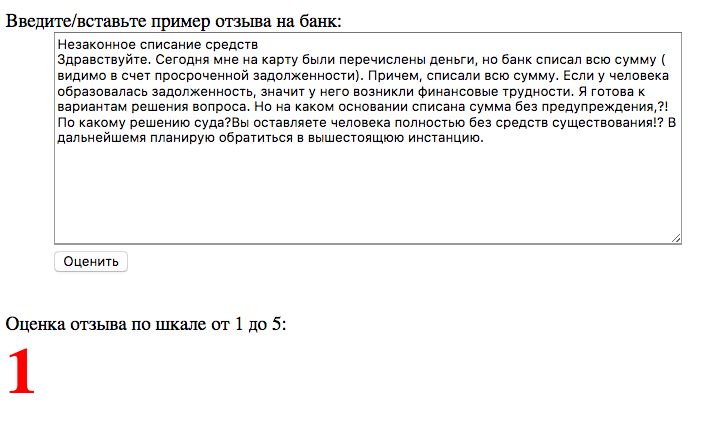

In [21]:
Image(filename='screens/label1.png')

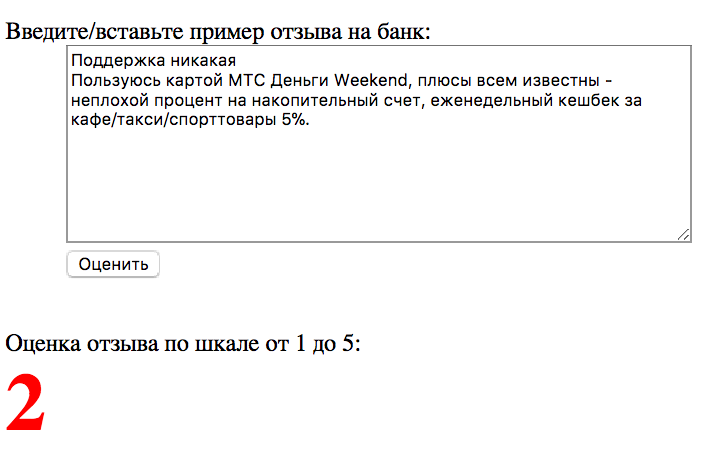

In [22]:
Image(filename='screens/label2.png')

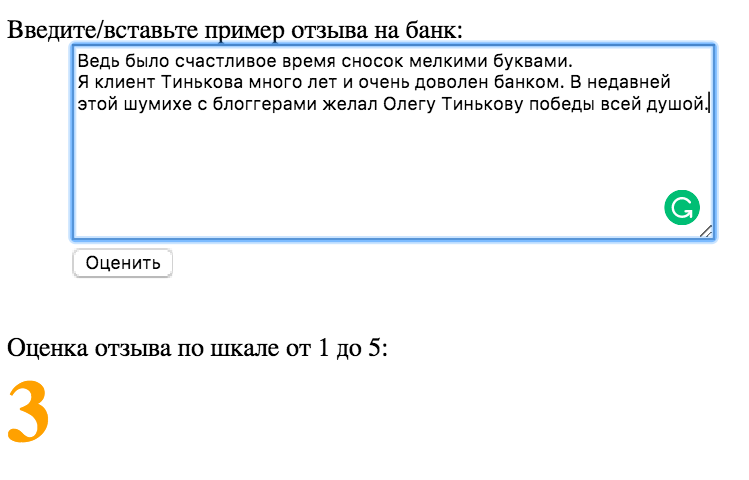

In [23]:
Image(filename='screens/label3.png')

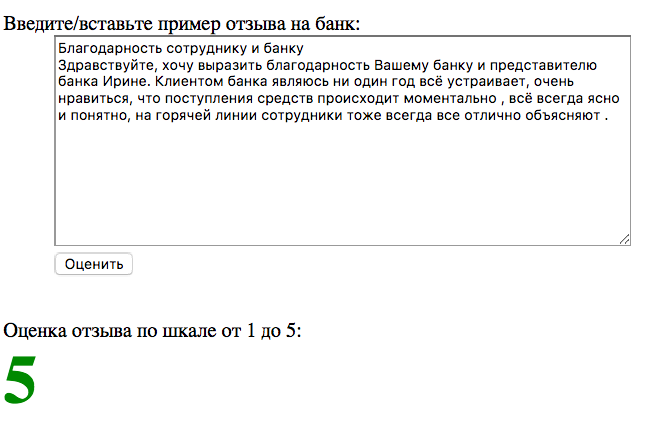

In [24]:
Image(filename='screens/label5.png')